In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import matplotlib.pyplot as plt

from IPython.display import clear_output
import time

In [17]:
from tensorflow.keras.layers import Layer
from tensorflow.python.eager import context
from tensorflow.python.framework import common_shapes
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import standard_ops
from tensorflow.keras import backend as K



class PolymorphicDense(Layer):

    def __init__(self,
               units,
               modes,
               key_size,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(PolymorphicDense, self).__init__(
            activity_regularizer=regularizers.get(activity_regularizer), **kwargs)
        self.units = int(units)
        self.modes = int(modes)
        self.key_size = int(key_size)
        
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.supports_masking = True
        self.input_spec = InputSpec(min_ndim=2)

    def build(self, input_shape):
        dtype = dtypes.as_dtype(self.dtype or K.floatx())
        if not (dtype.is_floating or dtype.is_complex):
            raise TypeError('Unable to build `LookupDense` layer with non-floating point '
                          'dtype %s' % (dtype,))
        input_shape = tensor_shape.TensorShape(input_shape)
        if tensor_shape.dimension_value(input_shape[-1]) is None:
            raise ValueError('The last dimension of the inputs to `LookupDense` '
                           'should be defined. Found `None`.')
        self.last_dim = tensor_shape.dimension_value(input_shape[-1])
        self.input_spec = InputSpec(min_ndim=2,
                                    axes={-1: self.last_dim})
        
        
#         self.similarity_sensitivity = self.add_weight(
#             'similarity_sensitivity',
#             shape=[],
#             initializer=self.kernel_initializer,
#             regularizer=self.kernel_regularizer,
#             constraint=self.kernel_constraint,
#             dtype=self.dtype,
#             trainable=True)
        
#         self.input_scaling = self.add_weight(
#             'input_scaling',
#             shape=[self.last_dim],
#             initializer=self.kernel_initializer,
#             regularizer=self.kernel_regularizer,
#             constraint=self.kernel_constraint,
#             dtype=self.dtype,
#             trainable=True)
        
        self.key_kernel = self.add_weight(
            'key_kernel',
            shape=[self.last_dim, self.key_size],
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            dtype=self.dtype,
            trainable=True)
        
        self.key_bias = self.add_weight(
            'key_bias',
            shape=[self.key_size],
            initializer=self.bias_initializer,
            regularizer=self.bias_regularizer,
            constraint=self.bias_constraint,
            dtype=self.dtype,
            trainable=True)
        
        self.keys_map = self.add_weight(
            'keys_map',
            shape=[self.modes, self.key_size],
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            dtype=self.dtype,
            trainable=True)
        
        self.kernels = self.add_weight(
            'kernels',
            shape=[self.modes, self.last_dim, self.units],
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            dtype=self.dtype,
            trainable=True)
        
        if self.use_bias:
            self.biases = self.add_weight(
              'biases',
              shape=[self.modes, self.units],
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              dtype=self.dtype,
              trainable=True)
        else:
            self.biases = None
        super(PolymorphicDense, self).build(input_shape)
        
    def call(self, inp):
        inputs = inp
        shape = inputs.shape.as_list()
        rank = common_shapes.rank(inputs)
        
        print('inputs')
        print(inputs.shape)
        
        key = standard_ops.tensordot(inputs, self.key_kernel, [[rank-1], [0]])
        
        print('key')
        print(key.shape)
        
        print('key_bias')
        print(self.key_bias.shape)
        key = key + self.key_bias
        
        print('key')
        print(key.shape)
        
        def similarity(keys, keys_table):
            a = tf.expand_dims(keys, -2)
            dist = tf.math.sqrt(tf.math.reduce_sum(tf.pow(a-keys_table, 2), axis=-1))
            return 1. / (dist + 1.)
        
        raw_similarity = similarity(key, self.keys_map)
        
        print('raw_similarity')
        print(raw_similarity.shape)
        
        key_similarity = raw_similarity
        key_similarity=tf.expand_dims(key_similarity, -1)
        key_similarity=tf.expand_dims(key_similarity, -1)
        weighted_weights = key_similarity * self.kernels
        
        print('weighted_weights')
        print(weighted_weights.shape)
        
        def replace_none(x):
            if x is None:
                return -1
            return x
        
        kernel = tf.math.reduce_mean(weighted_weights, axis=-3)
        
        print('kernel')
        print(kernel.shape)
        
        def broadcasted_matmul(a, b):
            return tf.math.reduce_sum(tf.expand_dims(a, -1) * b, axis=-2)
        
        outputs = broadcasted_matmul(inputs, kernel)
        
        print('output')
        print(outputs.shape)
        
        if self.use_bias:
            key_similarity = raw_similarity
            key_similarity=tf.expand_dims(key_similarity, -1)
            weighted_biases = key_similarity * self.biases
            
            print('weighted_biases')
            print(weighted_biases.shape)
            
            bias = tf.math.reduce_mean(weighted_biases, axis=-2)
            
            print('bias')
            print(bias.shape)
            
            outputs = outputs + bias
            
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if tensor_shape.dimension_value(input_shape[-1]) is None:
            raise ValueError(
                'The innermost dimension of input_shape must be defined, but saw: %s'
                % input_shape)
        return input_shape[:-1].concatenate(self.units)

    def get_config(self):
        config = {
            'units': self.units,
            'modes': self.modes,
            'key_size': self.key_size,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(PolymorphicDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

tf.keras.backend.clear_session()

inp = tfkl.Input(shape=[1])
hid = inp
hid = PolymorphicDense(units=1, modes=10, key_size=1)(hid)

model = tf.keras.Model(inputs = inp, outputs = hid)
model.summary()

optimizer = tf.optimizers.Nadam(.1)
model.compile(loss='MSE', optimizer=optimizer)

inps = 201
scope = 10
v_scaling = 2
x = np.reshape(np.linspace(-scope, scope, inps), [-1, 1])
y = np.sin(x*15/scope)*x+x

vx = np.reshape(np.linspace(-int(scope*v_scaling), int(scope*v_scaling), inps), [-1, 1])
vy = np.sin(vx*15/scope)*vx+vx


model.fit(x=x, y=y, epochs=1, verbose=0)

inputs
(None, 1)
key
(None, 1)
key_bias
(1,)
key
(None, 1)
raw_similarity
(None, 10)
weighted_weights
(None, 10, 1, 1)
kernel
(None, 1, 1)
output
(None, 1)
weighted_biases
(None, 10, 1)
bias
(None, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
polymorphic_dense (Polymorph (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


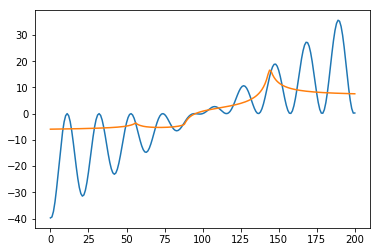

In [19]:
for step in range(30):
    model.fit(x=x, y=y, epochs=1, verbose=0)
    vy_ = np.reshape(model.predict(vx), [-1])
    clear_output(wait=True)
    
    vyr = np.reshape(vy, [-1])
    plt.plot(vyr)
    plt.plot(vy_)
    plt.show()